In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [4]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Bicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$. Assume the wheelbase of the vehicle $L$ = 0.9 m

In [23]:
@test 
def bicycle_model(curr_pose, v, delta, dt=0.1):
    '''
    >>> bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
    (0.0, 0.0, 0.0) 
    >>> bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
    (1.0, 0.0, 1.11) 
    '''
    # write code to calculate next_pose
    # refer to the kinematic equations of a bicycle model
    L=0.9
    x, y, theta = curr_pose 
    x += v*np.cos(theta)*dt 
    y += v*np.sin(theta)*dt
    theta += (v/L)*np.tan(delta)*dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))
    # return calculated (x, y, theta)
    #x=round(x,1)
    #y=round(y,1)
    #theta=round(theta,2)
    return x, y, theta

Finding tests in bicycle_model
Trying:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
**********************************************************************
File "__main__", line 4, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expected:
    (1.0, 0.0, 0.0)
Got:
    (0.1, 0.0, 0.0)
Trying:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expecting:
    (0.0, 0.0, 0.0) 
**********************************************************************
File "__main__", line 6, in bicycle_model
Failed example:
    bicycle_model((0.0,0.0,0.0), 0.0, np.pi/4)
Expected:
    (0.0, 0.0, 0.0) 
Got:
    (0.0, 0.0, 0.0)
Trying:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expecting:
    (1.0, 0.0, 1.11) 
**********************************************************************
File "__main__", line 8, in bicycle_model
Failed example:
    bicycle_model((0.0, 0.0, 0.0), 1.0, np.pi/4)
Expected:
    (1.0, 0.0, 1.11) 
Got:
    (0.1, 0.0, 0.1111111111111111)


In [24]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and delta values
all_v= np.ones(steps)
delta=0
for v in all_v:
  straight_trajectory.append(pose)
  pose=bicycle_model(pose,v,delta)

straight_trajectory=np.array(straight_trajectory)
print(straight_trajectory)  

[[0.00000000e+00 0.00000000e+00 1.57079633e+00]
 [6.12323400e-18 1.00000000e-01 1.57079633e+00]
 [1.22464680e-17 2.00000000e-01 1.57079633e+00]
 [1.83697020e-17 3.00000000e-01 1.57079633e+00]
 [2.44929360e-17 4.00000000e-01 1.57079633e+00]
 [3.06161700e-17 5.00000000e-01 1.57079633e+00]
 [3.67394040e-17 6.00000000e-01 1.57079633e+00]
 [4.28626380e-17 7.00000000e-01 1.57079633e+00]
 [4.89858720e-17 8.00000000e-01 1.57079633e+00]
 [5.51091060e-17 9.00000000e-01 1.57079633e+00]]


In [25]:
#circle
circle_trajectory = []
pose = (0, 0, np.pi/2)
steps = 1000
#fill in v and delta values
all_v= np.ones(steps)
all_delta= np.ones(steps)
 
for v,delta in zip(all_v,all_delta):
    #instruction to take v, delta and compute new pose    
   circle_trajectory.append(pose)
   pose=bicycle_model(pose,v,delta) 
   # store new pose
   
circle_trajectory=np.array(circle_trajectory)
print(circle_trajectory)

[[ 0.00000000e+00  0.00000000e+00  1.57079633e+00]
 [ 6.12323400e-18  1.00000000e-01  1.74384163e+00]
 [-1.72182964e-02  1.98506499e-01  1.91688693e+00]
 ...
 [-1.12037158e+00  2.47288706e-01 -1.83222544e+00]
 [-1.14621772e+00  1.50686546e-01 -1.65918014e+00]
 [-1.15504459e+00  5.10768771e-02 -1.48613484e+00]]


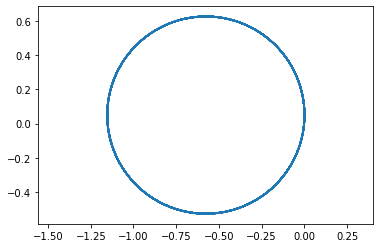

In [26]:
### Plot straight and circular trajectories
#plt.figure()
#plt.grid()
#plt.plot(straight_trajectory[:,0], straight_trajectory[:,1])

### Plot straight and circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circle_trajectory[:,0], circle_trajectory[:,1])
plt.show()

### Simulate Bicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\delta$. To make it even simpler, $\delta$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\delta = \delta_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\delta_c$?
* When should $\delta$ change from 0 and back?

In [27]:
v_c = 1# m/s
delta_c = np.pi/6 # rad

#calculate time taken to finish a quarter turn (pi/2)
# unlike you would need to take into account v_c and L of the vehicle as well
t_turn = int(np.pi/2/delta_c)

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/v_c), int(5/v_c), int(8/v_c)

all_delta = [0]*t_straight1 + [delta_c]*t_turn + \
        [0]*t_straight2 + [delta_c]*t_turn + \
        [0]*t_straight3 + [-delta_c]*t_turn
all_v = v_c*np.ones_like(all_delta)

In [28]:
print(all_delta)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0, 0, 0, 0, 0, 0.5235987755982988, 0.5235987755982988, 0.5235987755982988, 0, 0, 0, 0, 0, 0, 0, 0, -0.5235987755982988, -0.5235987755982988, -0.5235987755982988]


Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_delta

In [30]:
def get_open_loop_commands(route, vc, deltac):
    all_delta = []
    omegas = {'straight': 0, 'left': deltac, 'right': -deltac}
    for manoeuvre, command in route:
      u = np.ceil(command/vc).astype('int')
      v = np.ceil(np.deg2rad(command)/deltac).astype('int')
      t_cmd = u if manoeuvre == 'straight' else v
      all_delta += [omegas[manoeuvre]]*t_cmd
    all_v = vc*np.ones_like(all_w)
    return all_v, all_delta

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $delta_c = \pi/12$

In [31]:
robot_trajectory = []
vc=1
deltac=np.pi/12
all_v, all_delta = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)],vc,deltac)
pose = (0, 0, np.pi/2)
for v, delta in zip(all_v, all_delta):
   robot_trajectory.append(pose)
   pose=bicycle_model(pose,v,delta,1.0)

robot_trajectory=np.array(robot_trajectory)

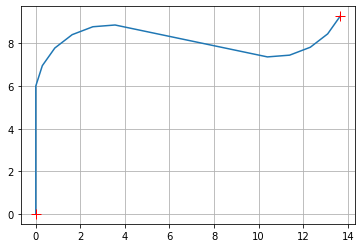

In [32]:
# plot robot trajectory
plt.figure()
plt.grid()
plt.plot(robot_trajectory[:,0],robot_trajectory[:,1] )

#show first and last robot positions with + markers
# example: plt.plot(0, 0, 'r+', ms=10)
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi, yi, 'r+', ms=10)
plt.plot(xf,yf, 'r+',ms=10)

### Shape the turn
Let us try something cooler than before (though a bit tricky in open loop). Instead of boring circular arcs, change the steering angle so that the robot orientation changes as shown in the equation below

$\theta = (\theta_i - \theta_f) * (1 - 3x^2 + 2\theta^3) + \theta_f  \thinspace \vee x \in [0,1]$

First let us plot this

In [15]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f



```
# This is formatted as code
```

How does a right turn look? 

In [16]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))
print(theta_dot)

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


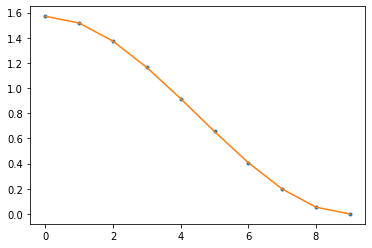

In [17]:
plt.figure()
plt.plot(poly_turn(np.pi/2, 0),'.')
plt.plot(poly_turn(np.pi/2, 0))

Now plot a left turn (North to East)

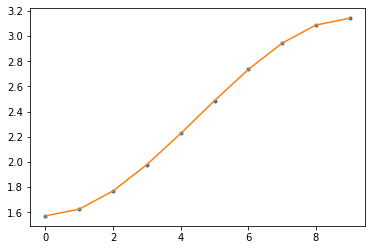

In [18]:
plt.figure()
plt.plot(poly_turn(np.pi/2,np.pi),'.')
plt.plot(poly_turn(np.pi/2,np.pi))

*How* does $\theta$ change when we had constant $\delta$? Plot it

In [51]:
delta=np.pi/6
theta_change=[]
dt=1.0
theta=0
for i in range(10):
  theta_change.append(theta)
  theta += v/L* np.tan(delta)*dt
  

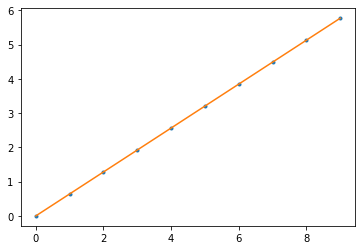

In [52]:
plt.figure()
plt.plot(theta_change,'.')
plt.plot(theta_change)

**We** know the rate of change of $\theta$ is proportional to $\delta$. Can you work out the sequence of $\delta$ to change $\theta$ as in the cubic polynomial shown above?

In [54]:
def poly_turn(theta_i, theta_f, n=10):
    x = np.linspace(0, 1, num=n)
    return (theta_i-theta_f) * (1 - 3 * x * x + 2 * (x**3)) + theta_f

In [55]:
theta_dot = np.diff(poly_turn(np.pi/2, 0))
print(theta_dot)

[-0.05386819 -0.14436674 -0.20900856 -0.24779366 -0.26072202 -0.24779366
 -0.20900856 -0.14436674 -0.05386819]


In [56]:
v=1
L=0.9
delta=np.arctan(L/v*theta_dot)
print(delta)

[-0.04844344 -0.12920623 -0.18593495 -0.21942362 -0.23048008 -0.21942362
 -0.18593495 -0.12920623 -0.04844344]
